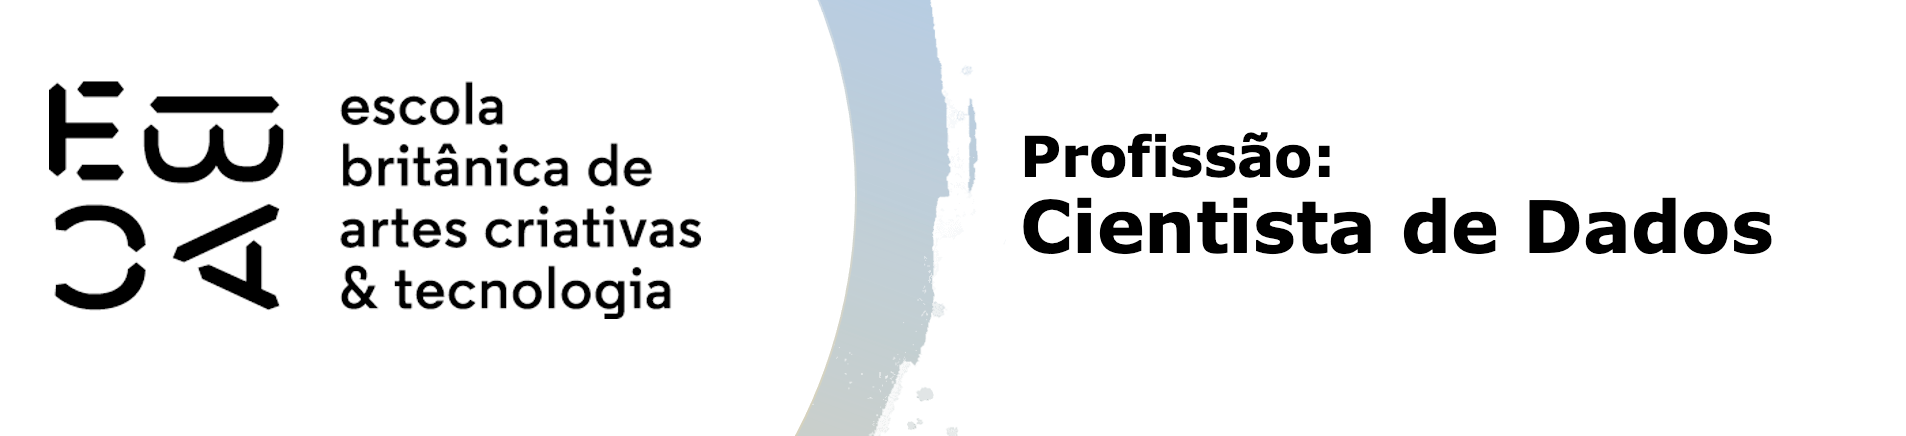

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.stats import t

import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Criando uma coluna com ano e mês:

df['data_ym'] = df['data_ref'].dt.strftime('%Y-%m')

# Ultimos 3 mêses da base de dados:

m = list(df['data_ym'].unique()[-3:])
m

['2016-01', '2016-02', '2016-03']

In [4]:
# Separando dados de treino e validação:

df_treino = df[df['data_ym'] < '2016-01']
df_val = df[df['data_ym'] >= '2016-01']

# Criando uma tabela de metadados:

metadados = pd.DataFrame({'dtypes': df.dtypes})
metadados['missing'] = df.isnull().sum()
metadados['valores_unicos'] = df.nunique()

metadados

,dtypes,missing,valores_unicos
data_ref,datetime64[ns],0,15
index,int64,0,16650
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


### Criando funções para automatizar as análises descritivas:

In [5]:
# Criação de tabela cruzada da variável com o alvo:

def tab(df, var, nqcut=None):
    tabela = None
    if df[var].dtype == 'object':
        '''Cria uma tabela cruzada de uma variável em relação a variável alvo
            contendo taxa do evento, porcentagem do evento e não evento, WOE e
            IV parcial.'''

        tab = pd.crosstab(
                [df['data_ym'], df[var]], df['mau'].astype(int), 
                margins=True, margins_name='total')

        tab['tx_evento'] = tab[1]/tab[0]
        tab['pct_evento'] = tab[1]/tab[1].groupby(level=0).sum()
        tab['pct_nao_evento'] = tab[0]/tab[0].groupby(level=0).sum()
        tab['woe'] = np.log(tab['pct_evento']/tab['pct_nao_evento'])
        tab['iv_parc'] = (tab['pct_evento'] - tab['pct_nao_evento'])*tab['woe']

        tabela = tab
  
    else:
        '''Cria uma tabela cruzada de uma variável em relação a variável alvo
        contendo taxa do evento, porcentagem do evento e não evento, WOE e
        IV parcial.'''

        tab = pd.crosstab(
        [df['data_ym'], pd.qcut(df[var], 5, duplicates='drop')],
        df['mau'].astype(int),
        margins=True, margins_name='total')

        tab['tx_evento'] = tab[1]/tab[0]
        tab['pct_evento'] = tab[1]/tab[1].groupby(level=0).sum()
        tab['pct_nao_evento'] = tab[0]/tab[0].groupby(level=0).sum()
        tab['woe'] = np.log(tab['pct_evento']/tab['pct_nao_evento'])
        tab['iv_parc'] = (tab['pct_evento'] - tab['pct_nao_evento'])*tab['woe']

        tabela = tab
    
    return tabela

# Information Value no tempo:

def IV(df, var, nqcut=None):

    iv = None

    if df[var].dtype == 'object':
        ''' Plota um gráfico do IV da variável
        ao longo dos tempo'''

        tabela = tab(df, var)
        iv = tabela.groupby(level=0)['iv_parc'].sum().drop('total', axis=0)        
  
    else:
        ''' Plota um gráfico do IV da variável
        ao longo dos tempo'''

        tabela = tab(df, var, nqcut)
        iv = tabela.groupby(level=0)['iv_parc'].sum().drop('total', axis=0)

    plt.title(f'Information Value no tempo da variável: {var}')
    sns.pointplot(x=iv.index, y=iv)
    plt.ylabel('IV')
    plt.xlabel('Data')
    plt.xticks(rotation=30)
    plt.ylim(0, iv.max()*1.2)
    
    return None

# Descritiva (Categórica):

def desc_cat(df, var):
    ''' Da uma descrição estatística da variável em relação ao alvo, gera gráficos do WOE
    com intervalo de confiânca para cada classe e gera um gráfico da distribuição da variável'''

    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    ax[1].set_xticklabels(biv[var], rotation=15)

    plt.subplots_adjust(hspace=0.5)
    
    return biv

# Descritiva (Numérica):

def desc_num(df, var, ncat):
    ''' Da uma descrição estatística da variável em relação ao alvo, gera gráficos do WOE
    com intervalo de confiânca para os intervalos da variável e gera um gráfico da distribuição 
    da variável em intervalos'''

    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()

    plt.subplots_adjust(hspace=0.5)
    return None

# Histograma da variável (Numérica):

def histplot(df, var, bin='auto'):
    '''Gera um histograma da variável'''

    plt.title(f'Histograma da variável: {var}')

    sns.histplot(data=df, x=var, bins=bin)
    plt.ylabel('Contagem')

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [6]:
df_treino.drop(columns=['data_ref', 'index'], inplace=True)

print(f'Número de linhas: {df_treino.shape[0]}')

Número de linhas: 600000


In [7]:
print('Número de clientes registrados por mês:\n')

df_treino.groupby('data_ym')['renda'].count()

Número de clientes registrados por mês:



data_ym
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
Name: renda, dtype: int64

In [8]:
print(f'Informações gerais sobre o dataset:')

df_treino.info()

Informações gerais sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  bool   
 13  data_ym                600000 non-null  object 
dtypes: bo

### Variáveis Categóricas:

In [9]:
print(f'Lista de variáveis categóricas:\n')

list(df_treino.select_dtypes('object').drop(columns=['data_ym']).columns)

Lista de variáveis categóricas:



['sexo',
 'posse_de_veiculo',
 'posse_de_imovel',
 'tipo_renda',
 'educacao',
 'estado_civil',
 'tipo_residencia']

* sexo:

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,378318,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


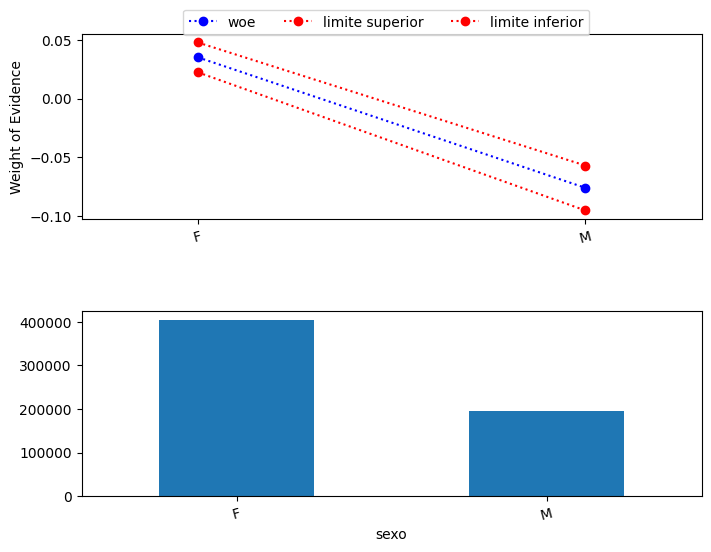

In [10]:
desc_cat(df_treino, 'sexo')

In [11]:
print('Proporções:')
pd.crosstab(df_treino['sexo'], df_treino['mau'], normalize=True)

Proporções:


mau,False,True
sexo,,
F,0.630530,0.042478
M,0.308398,0.018593


A variável sexo é desbalanceada, contendo muito mais entradas de clientes femininas em relação a clientes masculinos.

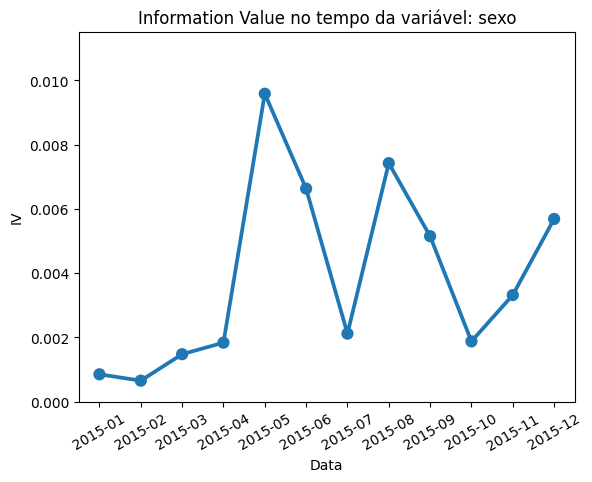

In [12]:
IV(df_treino, 'sexo')

Baixo Information Value para todo o período de treino. Indicando que a variável tem um poder preditívo fraco sobre a variável alvo.

* posse_de_veiculo

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,343778,22515,0.061467,N,366293,0.000397,0.062245,0.060689,-2.725814,-2.712410,-2.739378,0.006877,0.020281,-0.006687
S,219579,14128,0.060452,S,233707,0.000493,0.061418,0.059486,-2.743553,-2.726667,-2.760694,-0.010862,0.006024,-0.028003


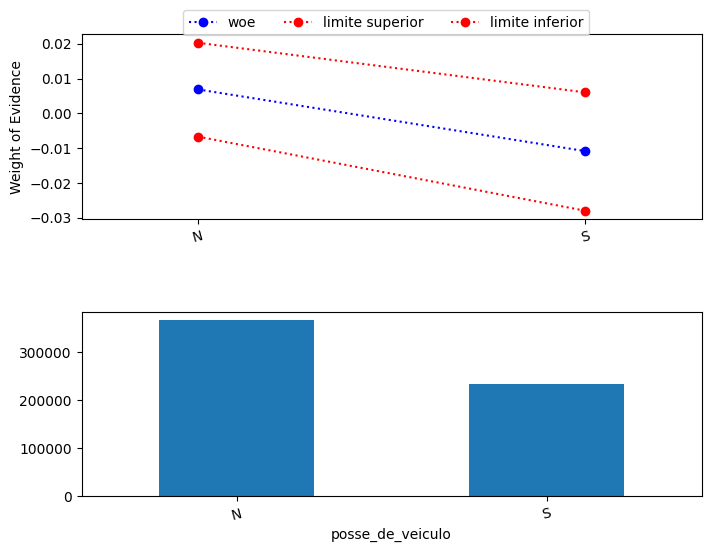

In [13]:
desc_cat(df_treino, 'posse_de_veiculo')

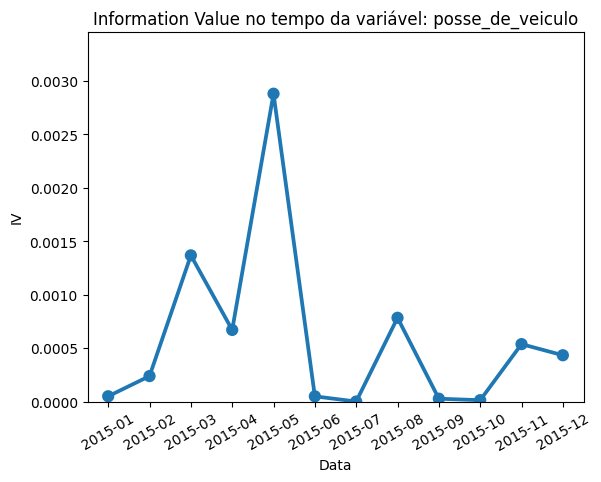

In [14]:
IV(df_treino, 'posse_de_veiculo')

IV baixíssimo em todo período de treino, indicando que a variável não tem poder preditivo sobre a variável alvo.

* posse_de_imovel

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,183305,13641,0.069263,N,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,380052,23002,0.057069,S,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


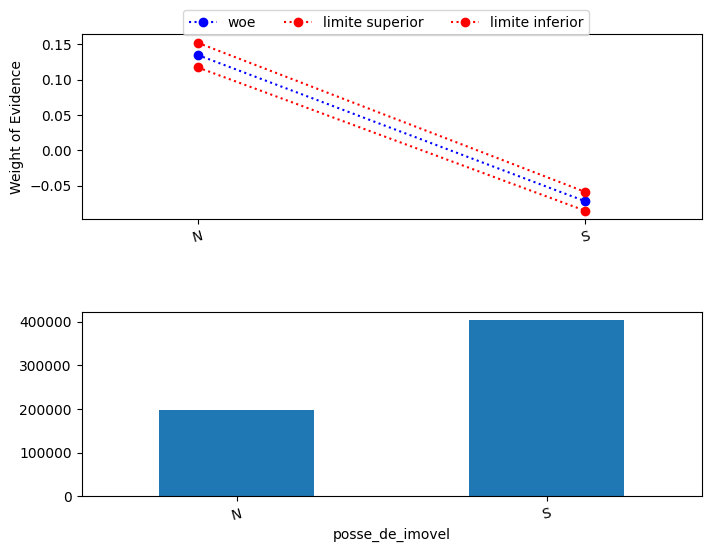

In [15]:
desc_cat(df_treino, 'posse_de_imovel')

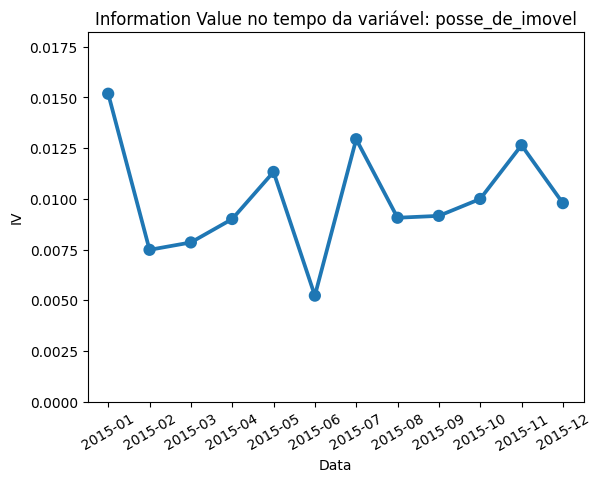

In [16]:
IV(df_treino, 'posse_de_imovel')

Baixíssimo Information Value em relação a variável alvo ao longo do tempo.

* tipo_renda

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


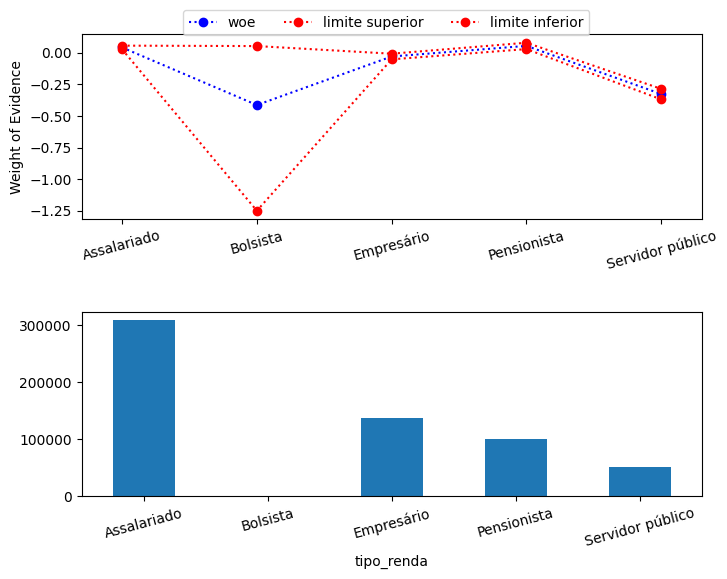

In [17]:
desc_cat(df_treino, 'tipo_renda')

In [18]:
print('Proporções:')
pd.crosstab(df_treino['tipo_renda'], df_treino['mau'], normalize=True)

Proporções:


mau,False,True
tipo_renda,,
Assalariado,0.481442,0.032658
Bolsista,0.000465,0.000020
Empresário,0.216558,0.013677
Pensionista,0.157712,0.010833
Servidor público,0.082752,0.003883


Como a classe 'Bolsista' é muito pequena, iremos agrupa-la a classe 'Servidor público'

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Serv. Público/Bolsista,49930,2342,0.044804,Serv. Público/Bolsista,52272,0.000905,0.046578,0.043031,-3.059617,-3.018938,-3.101860,-0.326926,-0.286247,-0.369169


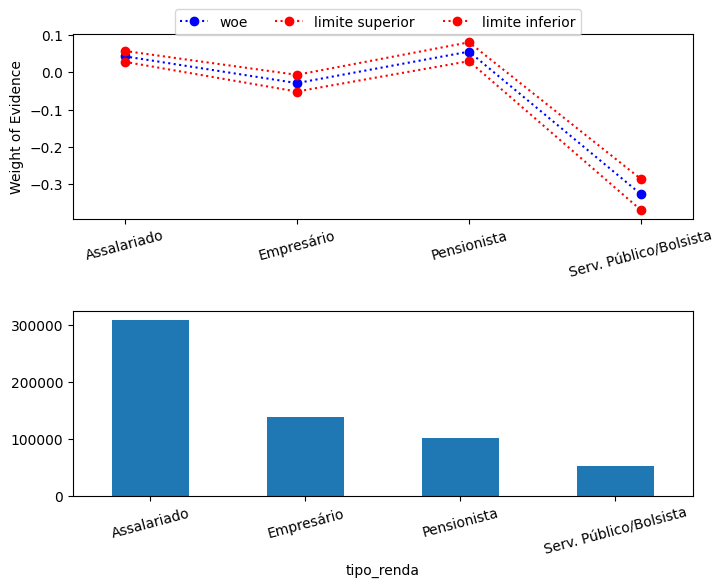

In [19]:
df_treino2 = df_treino.copy()

df_treino2['tipo_renda'].replace(
    {'Bolsista': 'Serv. Público/Bolsista', 
    'Servidor público': 'Serv. Público/Bolsista'}, 
    inplace=True)

desc_cat(df_treino2, 'tipo_renda')

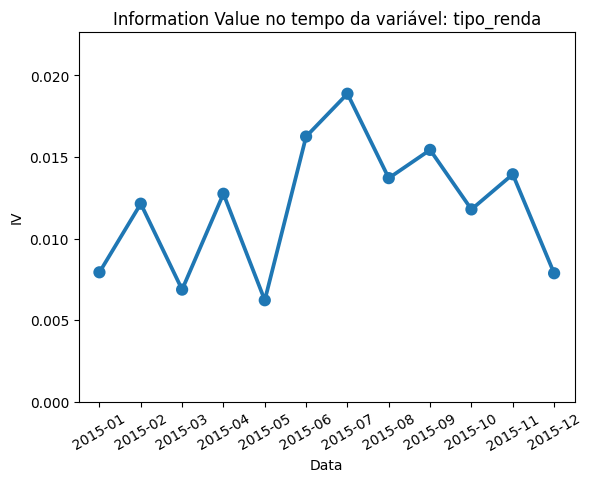

In [20]:
IV(df_treino2, 'tipo_renda')

Novamente um Information Value muito baixo, indicando que a variável tem um valor baixo de poder preditivo.

* educacao

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,379939,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,154354,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


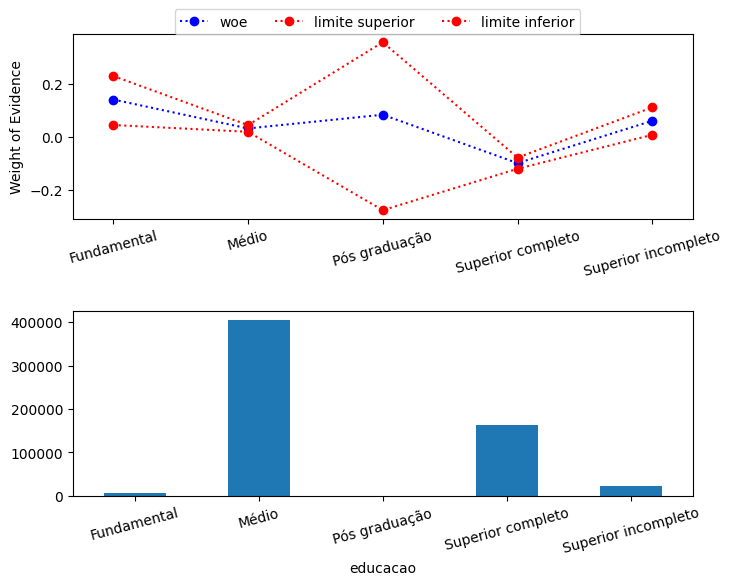

In [21]:
desc_cat(df_treino, 'educacao')

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Médio/Fundamental,386359,25991,0.063031,Médio/Fundamental,412350,0.000378,0.063773,0.062290,-2.699017,-2.686525,-2.711646,0.033674,0.046166,0.021045
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550
Superior/Pós,154962,9129,0.055634,Superior/Pós,164091,0.000566,0.056743,0.054525,-2.831724,-2.810810,-2.853034,-0.099033,-0.078119,-0.120342


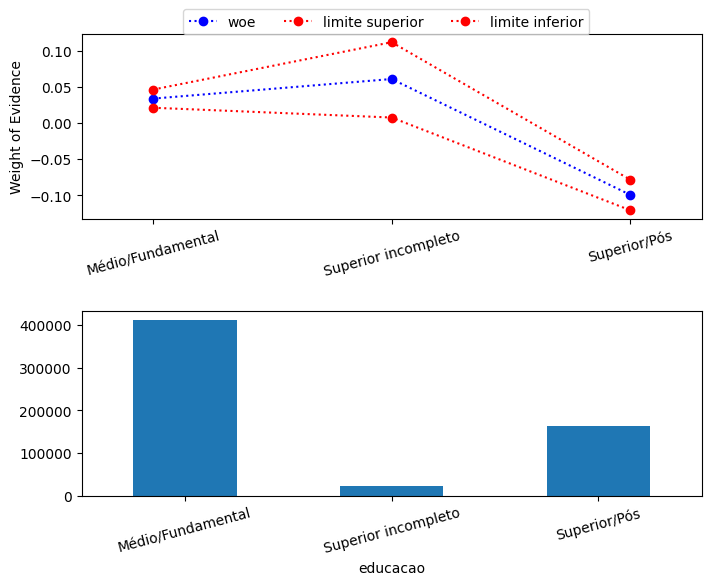

In [22]:
df_treino2['educacao'].replace(
    {'Superior completo': 'Superior/Pós',
    'Pós graduação': 'Superior/Pós',
    'Médio': 'Médio/Fundamental',
    'Fundamental': 'Médio/Fundamental'},
    inplace=True)

desc_cat(df_treino2, 'educacao') 

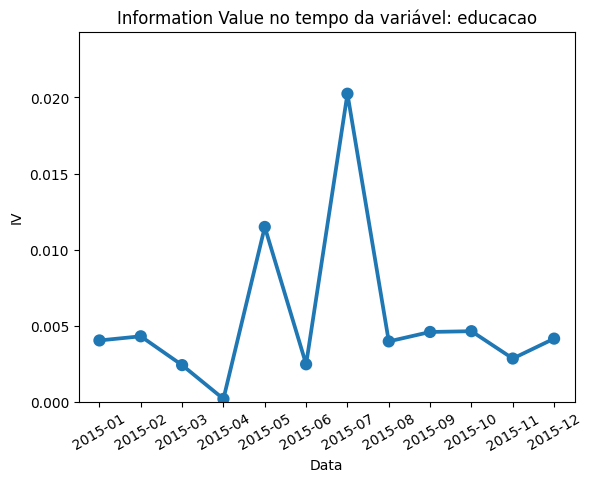

In [23]:
IV(df_treino2, 'educacao')

Baixíssimo Information Value.

* estado_civil

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,395880,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


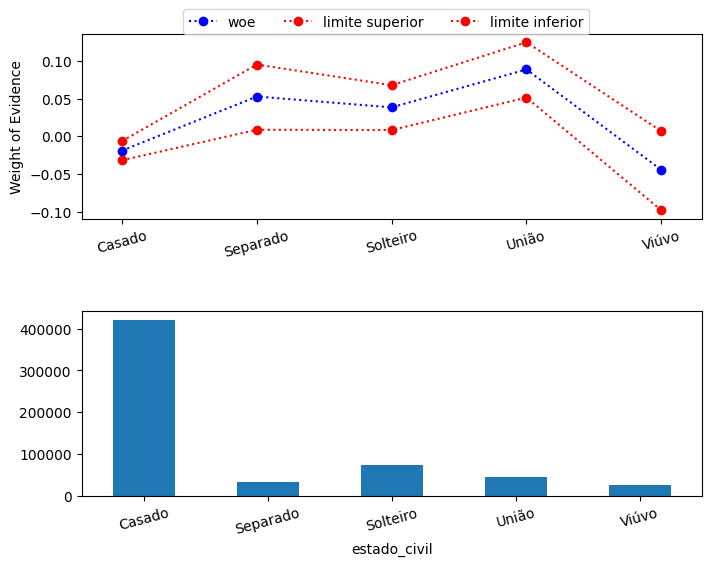

In [24]:
desc_cat(df_treino, 'estado_civil')

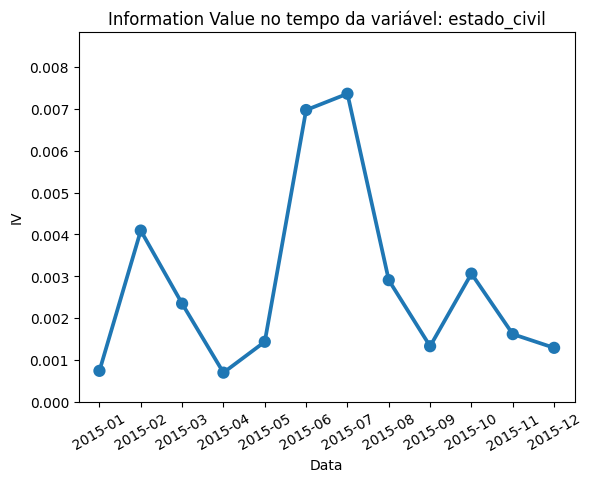

In [25]:
IV(df_treino, 'estado_civil')

Information Value insignificante para a predição da variável alvo.

* tipo_residencia

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


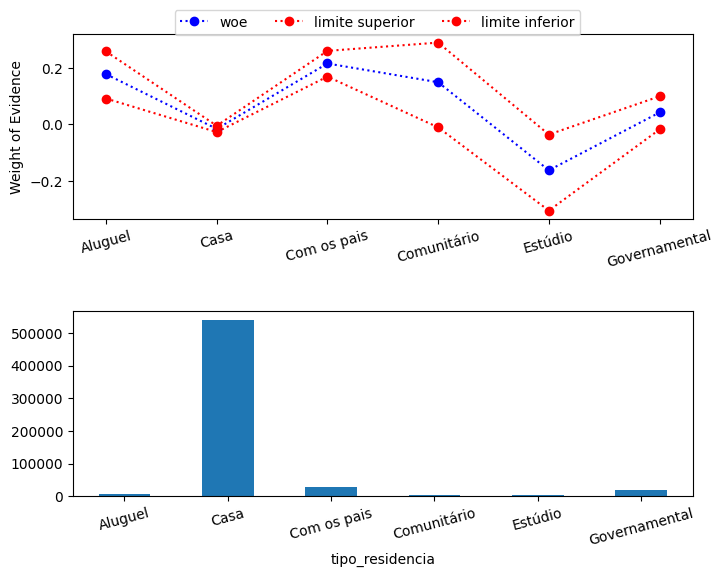

In [26]:
desc_cat(df_treino, 'tipo_residencia')

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com pais\Comunitário,27182,2182,0.074309,Com pais\Comunitário,29364,0.001531,0.077309,0.071309,-2.522313,-2.479490,-2.566757,0.210378,0.253202,0.165934
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


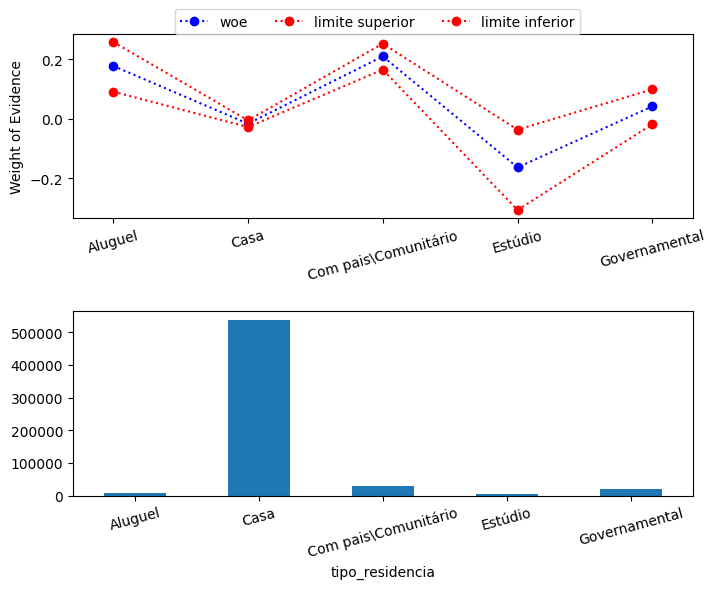

In [27]:
df_treino2['tipo_residencia'].replace({
    'Com os pais': 'Com pais\Comunitário',
    'Comunitário': 'Com pais\Comunitário'},
    inplace=True
)

desc_cat(df_treino2, 'tipo_residencia')

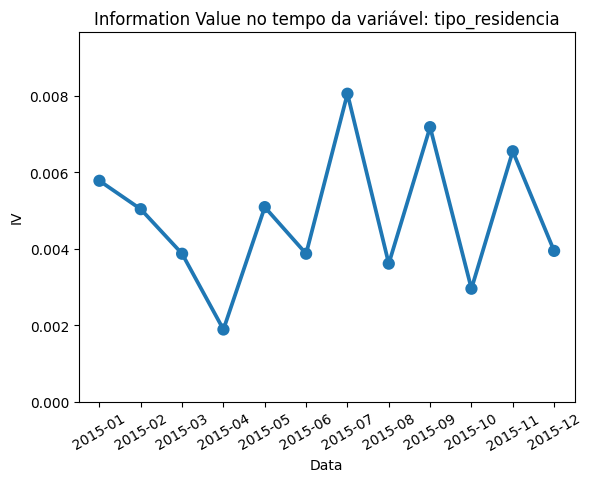

In [28]:
IV(df_treino2, 'tipo_residencia')

IV indica que a variável tem poder preditivo insignificante.

### Variáveis Numéricas:

In [29]:
print(f'Lista de variáveis numéricas:\n')

var = list(df_treino.select_dtypes('number').drop(columns=['bom']).columns)
var

Lista de variáveis numéricas:



['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

Inicialmente podemos nos atentar as variáveis 'qtd_filhos' e 'qt_pessoas_residencia' que aparentam conter informações muito correlcionadas

In [30]:
print('Correlação entre as duas variáveis:\n')

df_treino[['qt_pessoas_residencia', 'qtd_filhos']].corr()

Correlação entre as duas variáveis:



,qt_pessoas_residencia,qtd_filhos
qt_pessoas_residencia,1.000000,0.890439
qtd_filhos,0.890439,1.000000


Devido a alta correlação entre estas duas variáveis, excluiremos a variável 'qt_pessoas_residencia' Pois em análises anteriores esta variável apresntou um alto VIF (maior que 'qtd_filhos'), indicando que ela pode ser fortemente explicada pelas demais variáveis.

* idade

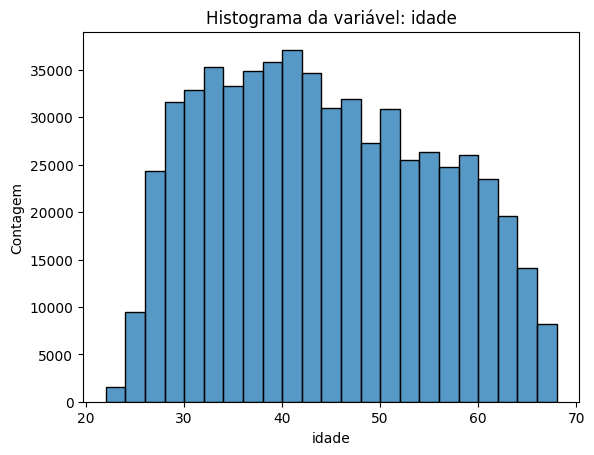

In [31]:
histplot(df_treino, 'idade', 23)

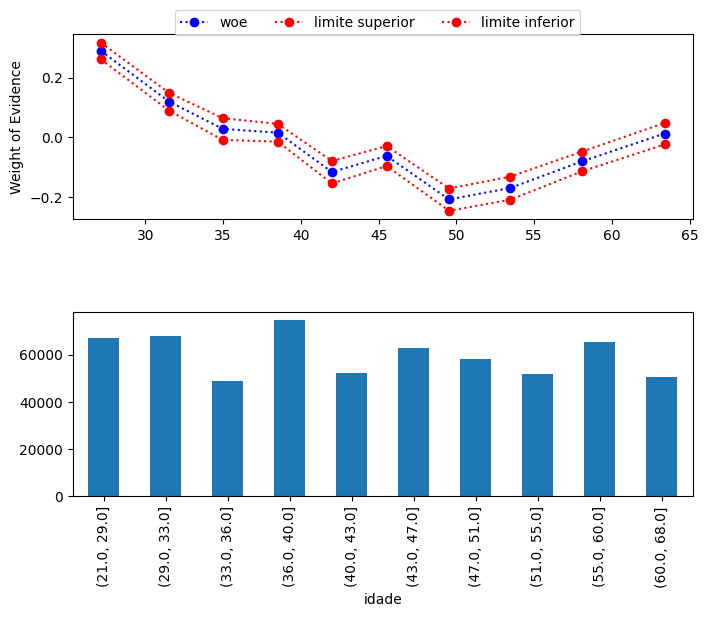

In [32]:
desc_num(df_treino, 'idade', 10)

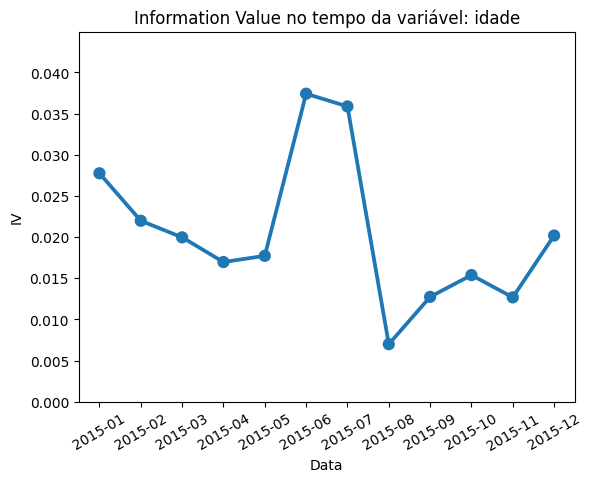

In [33]:
IV(df_treino, 'idade', 10)

IV significativo para previsão.

* tempo_emprego

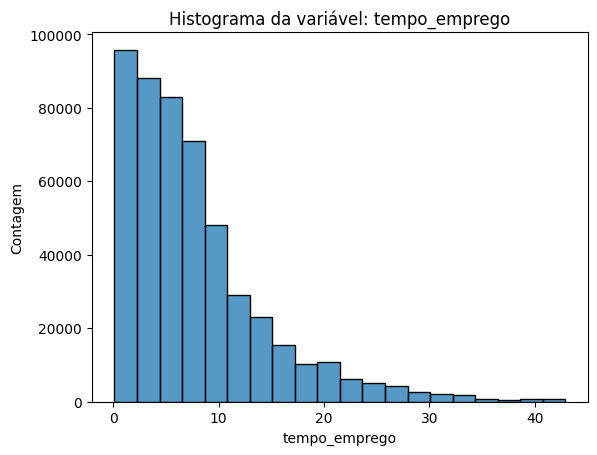

In [34]:
histplot(df_treino, 'tempo_emprego', 20)

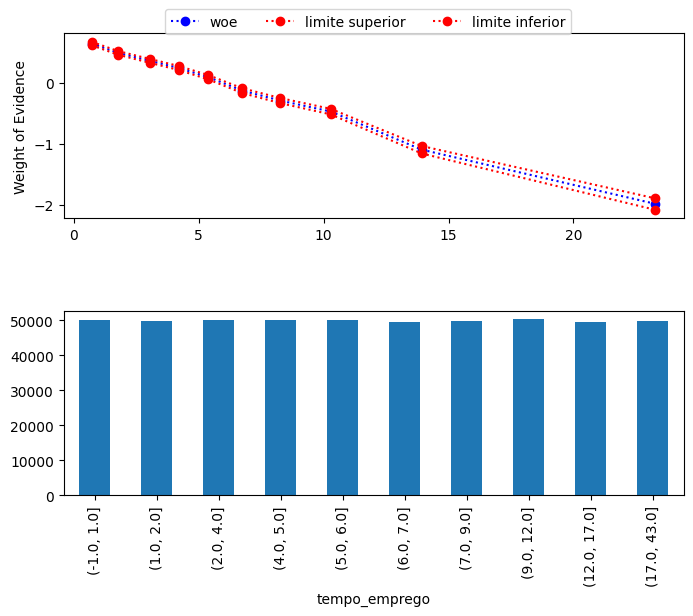

In [35]:
desc_num(df_treino, 'tempo_emprego', 10)

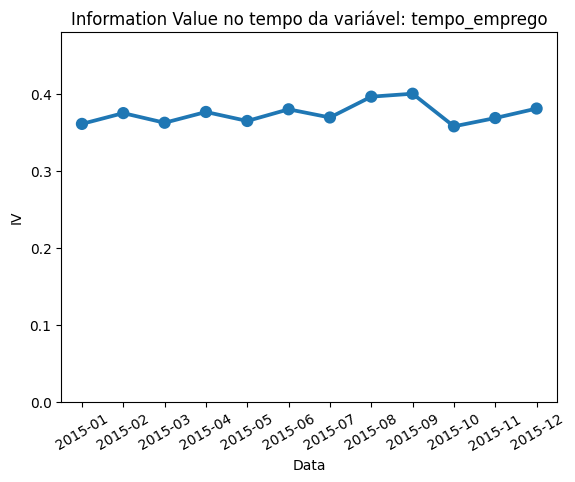

In [36]:
IV(df_treino, 'tempo_emprego', 10)

Novamente uma variável com poder significativo de previsão.

* renda

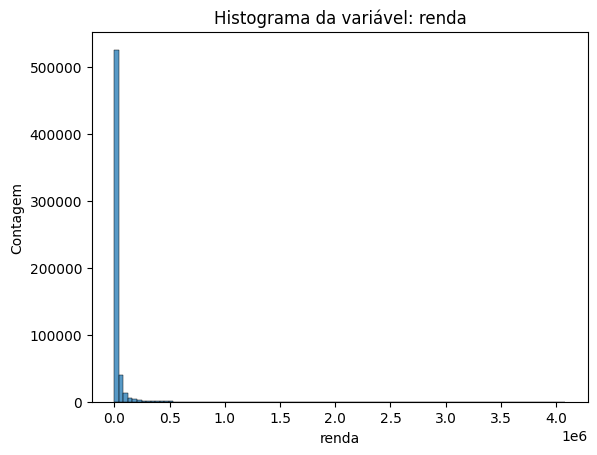

In [37]:
histplot(df_treino, 'renda', 100)

Ditribuição da renda é fortemente centrada e contém valores muito distântes da média.

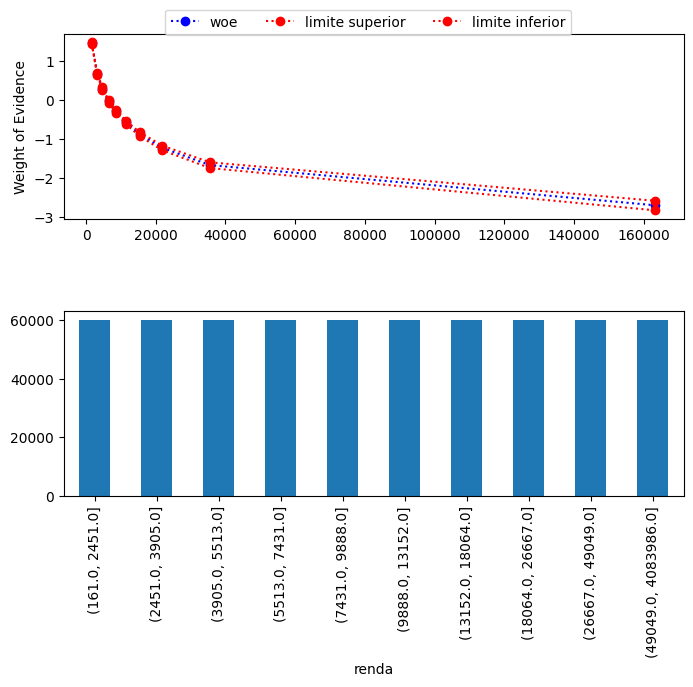

In [38]:
desc_num(df_treino, 'renda', 10)

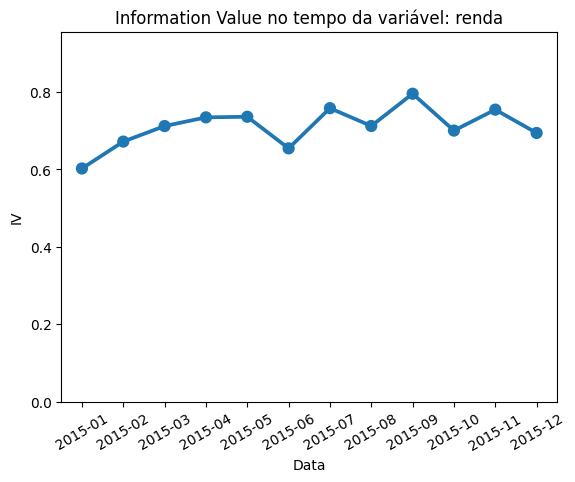

In [39]:
IV(df_treino, 'renda', 10)

Ótimo poder de previsão.

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [40]:
df_treino['log(renda)'] = df_treino['renda'].apply(lambda x: np.log(x))
df_treino2['log(renda)'] = df_treino2['renda'].apply(lambda x: np.log(x))

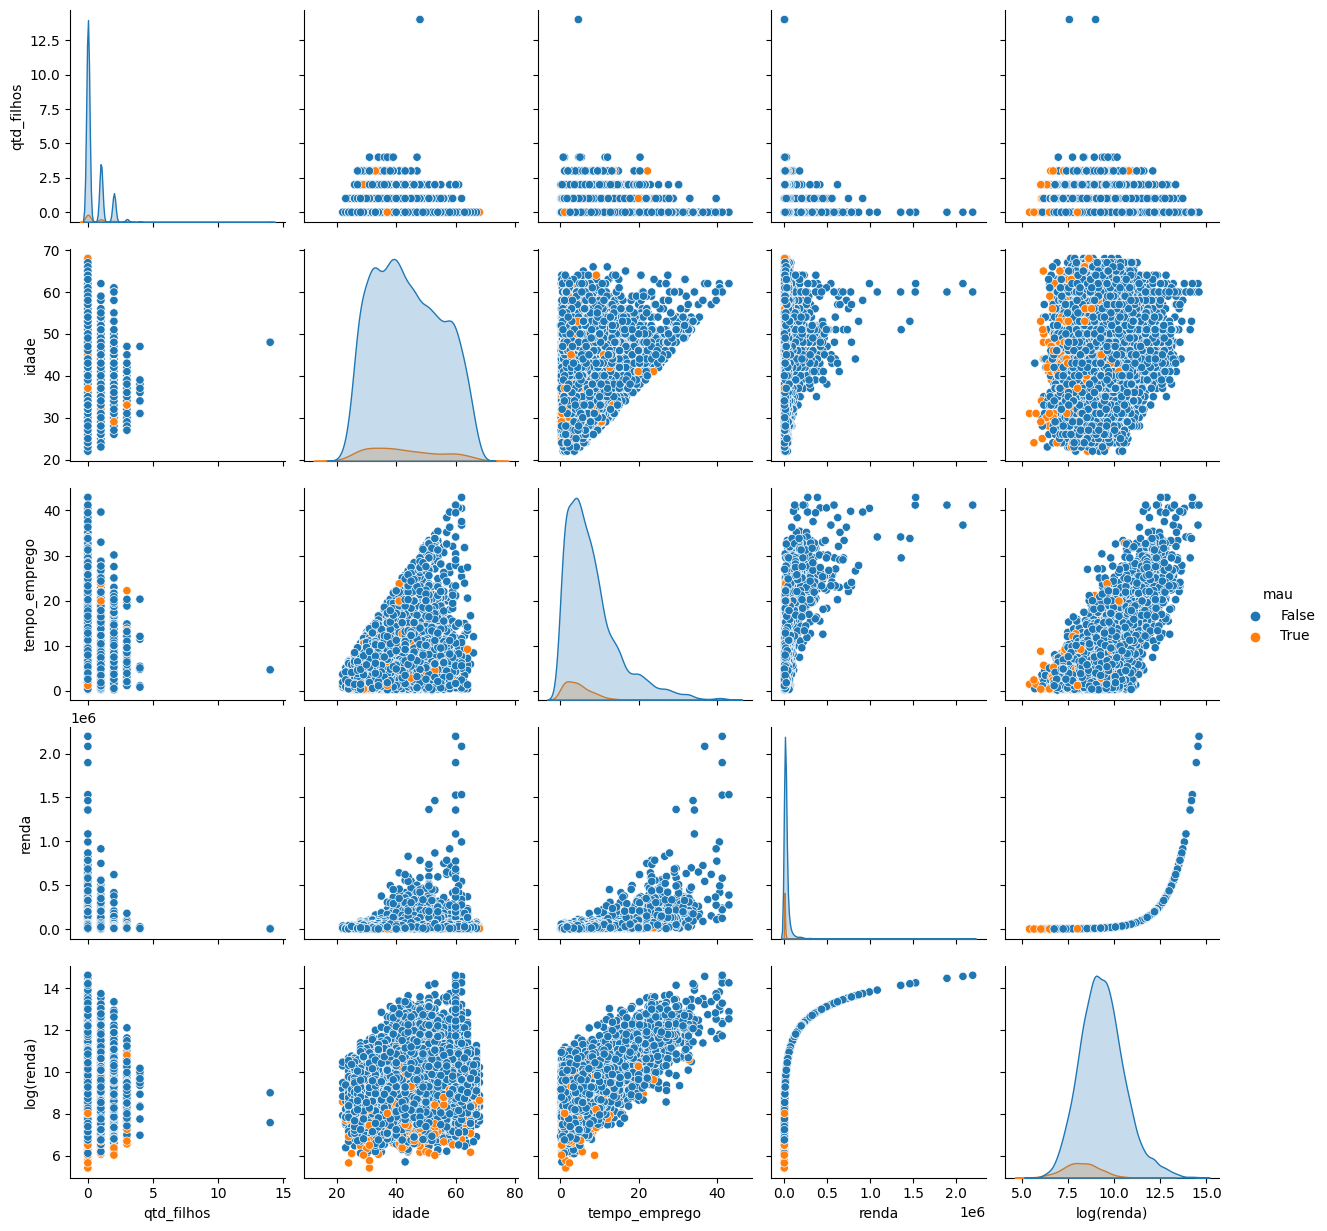

In [41]:
var_num = list(df_treino.select_dtypes('number').drop(
    columns=['qt_pessoas_residencia', 'bom']
    ).columns)

var_num.append('mau')

sns.pairplot(df_treino[var_num].sample(n=10000), hue='mau')

<Axes: xlabel='educacao', ylabel='log(renda)'>

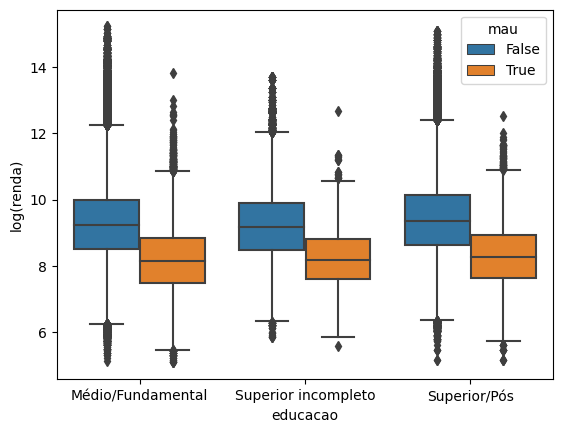

In [42]:
sns.boxplot(data=df_treino2, x='educacao', y='log(renda)', hue='mau')

Podemos notar que as distribuições contendo inadimplêntes tem uma média de renda mais baixa que a média da classe correspondente.

<Axes: xlabel='estado_civil', ylabel='log(renda)'>

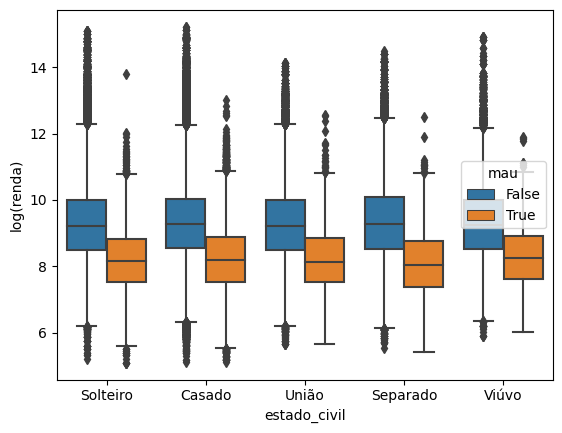

In [43]:
sns.boxplot(data=df_treino2, x='estado_civil', y='log(renda)', hue='mau')

<Axes: xlabel='qtd_filhos', ylabel='log(renda)'>

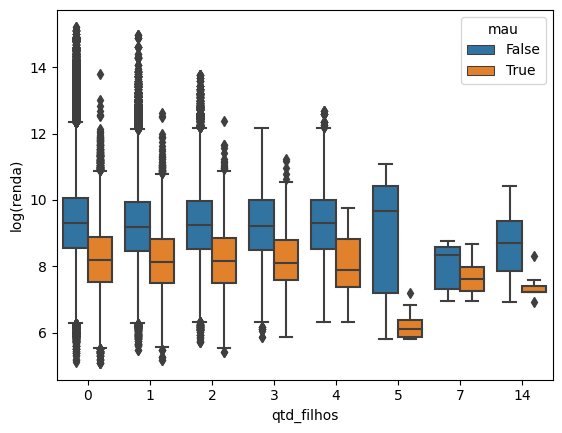

In [44]:
sns.boxplot(data=df_treino2, x='qtd_filhos', y='log(renda)', hue='mau')

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

Utilizaremos o dataset 'df_treino2'. Que contém alguns agrupamentos de classes das variáveis categóricas.

### Dados faltantes:

In [45]:
df_treino2.isnull().sum()

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
data_ym                       0
bom                           0
log(renda)                    0
dtype: int64

In [46]:
# Substituindo dados faltantes pela média

df_treino2.fillna(value=df_treino2['tempo_emprego'].mean(), inplace=True)

df_treino2.isnull().sum()

sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
data_ym                  0
bom                      0
log(renda)               0
dtype: int64

### Outliers:

In [47]:
# Verificando métricas das variáveis numéricas:

df_treino2[var_num].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,600000.0,0.433210,0.739869,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,600000.0,43.798530,11.230659,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,600000.0,7.747992,6.100461,0.117808,3.635616,7.473973,9.069863,4.290685e+01
renda,600000.0,27222.844732,87377.875997,161.860000,4670.600000,9887.580000,21628.870000,4.083986e+06
log(renda),600000.0,9.270446,1.212054,5.086732,8.449043,9.199035,9.981784,1.522258e+01


In [48]:
print('Porcentagens de dados discrepantes:')

print(f'qtd_filhos > 8: {round(df_treino2[df_treino2["qtd_filhos"] > 8].shape[0]/df_treino2.shape[0]*100,4)}%')
print(f'renda > 300000: {round(df_treino2[df_treino2["renda"] > 300000].shape[0]/df_treino2.shape[0]*100,4)}%')
print(f'renda < 500: {round(df_treino2[df_treino2["renda"] < 500].shape[0]/df_treino2.shape[0]*100,4)}%')

Porcentagens de dados discrepantes:
qtd_filhos > 8: 0.0118%
renda > 300000: 1.1382%
renda < 500: 0.2005%


In [49]:
# Removendo estes dados: 
df_treino2 = df_treino2[df_treino2['renda'] < 300000]
df_treino2 = df_treino2[df_treino2['renda'] > 500]
df_treino2 = df_treino2[df_treino2['qtd_filhos'] < 7]

Comparação para avaliar a remoção dos dados:

In [50]:
def box_comp(var):

    figs, axs = plt.subplots(1, 2, figsize=(12, 8))

    sns.boxplot(data=df_treino, y=var, ax=axs[0])
    axs[0].set_title('Dados originais')
    sns.boxplot(data=df_treino2, y=var, ax=axs[1])
    axs[1].set_title('Dados tratados')


    plt.show()

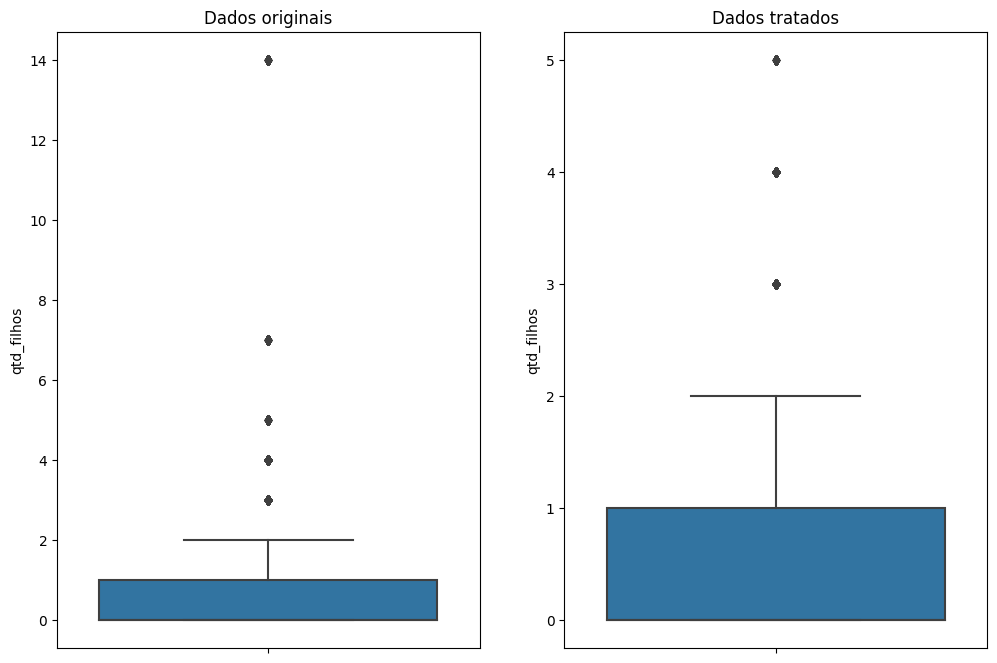

In [51]:
box_comp('qtd_filhos')

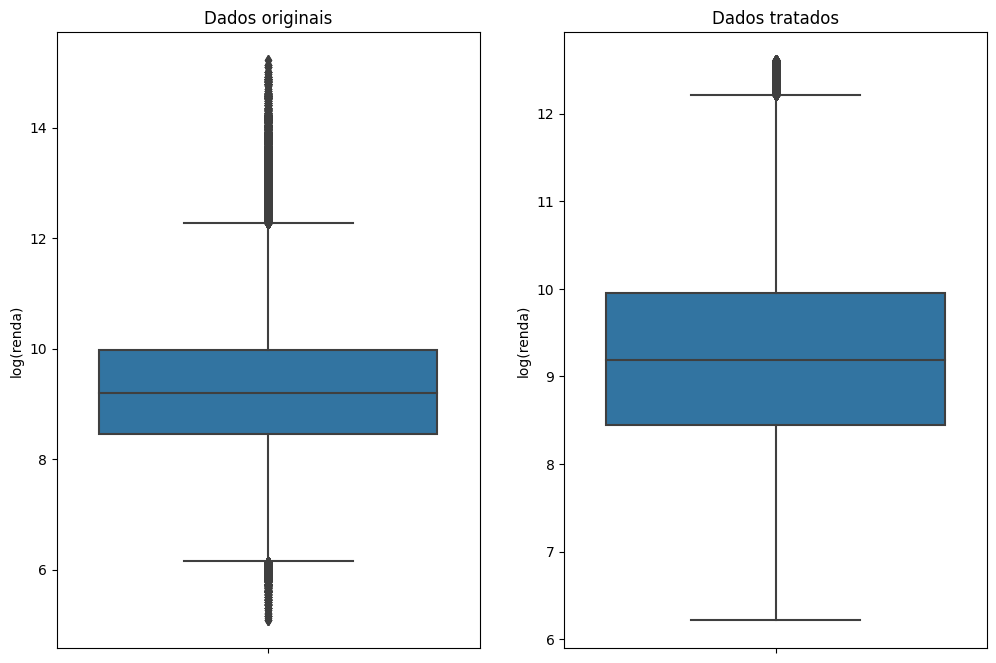

In [52]:
box_comp('log(renda)')

In [53]:
# Removendo algumas colunas que não serão importantes para o modelo:

df_treino2.drop(columns=[
    'bom', 'qt_pessoas_residencia', 'data_ym', 'log(renda)'
    ], inplace=True)

df_treino2['mau'] = df_treino2['mau'].astype(int)

In [54]:
# Criando os metadados da base de treino:

meta_treino = pd.DataFrame({'dtypes': df_treino2.dtypes})
meta_treino['nunique'] = df_treino2.nunique()
meta_treino['papel'] = 'covariavel'
meta_treino.loc['mau', 'papel'] = 'resposta'

meta_treino

,dtypes,nunique,papel
sexo,object,2,covariavel
posse_de_veiculo,object,2,covariavel
posse_de_imovel,object,2,covariavel
qtd_filhos,int64,6,covariavel
tipo_renda,object,4,covariavel
educacao,object,3,covariavel
estado_civil,object,5,covariavel
tipo_residencia,object,5,covariavel
idade,int64,47,covariavel
tempo_emprego,float64,3002,covariavel


In [55]:
# Definindo uma função para popular os metadados com o IV:

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [56]:
# Populando o metadados de treino com as IV das variáveis:

for var in meta_treino[meta_treino['papel']=='covariavel'].index:
    if  (meta_treino.loc[var, 'nunique']>6):
        meta_treino.loc[var, 'IV'] = IV(pd.qcut(df_treino2[var],25,duplicates='drop'), df_treino2['mau'])
    else: 
        meta_treino.loc[var, 'IV'] = IV(df_treino2[var], df_treino2['mau'])

    
meta_treino.sort_values(by='IV', ascending=False)

,dtypes,nunique,papel,IV
renda,float64,110846,covariavel,1.035185
tempo_emprego,float64,3002,covariavel,0.289521
idade,int64,47,covariavel,0.020020
posse_de_imovel,object,2,covariavel,0.008735
tipo_renda,object,4,covariavel,0.008292
tipo_residencia,object,5,covariavel,0.003294
educacao,object,3,covariavel,0.003055
sexo,object,2,covariavel,0.002714
estado_civil,object,5,covariavel,0.001281
qtd_filhos,int64,6,covariavel,0.000949


### Modelo:

In [57]:
f = ' + '.join(list(df_treino2.columns.drop(['mau'])))
f

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + renda'

In [58]:
formula = '''mau ~ sexo + posse_de_veiculo + posse_de_imovel
            + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia
            + idade + tempo_emprego + renda'''

rl = smf.logit(formula, data=df_treino2).fit()
rl.summary()

Optimization terminated successfully.
         Current function value: 0.208377
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               591815
Model:                          Logit   Df Residuals:                   591794
Method:                           MLE   Df Model:                           20
Date:                Sat, 04 May 2024   Pseudo R-squ.:                 0.09092
Time:                        13:16:07   Log-Likelihood:            -1.2332e+05
converged:                       True   LL-Null:                   -1.3565e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -1.4475      0.054    -26.860      0.000      -1.553      -1.342
sexo[T.M]                                  -0.1080      0.013     -8.181      0.000      -0.134      -0.082
posse_de_veiculo[T.S]                       0.0301      0.012      2.415      0.016       0.006       0.055
posse_de_imovel[T.S]                       -0.0798      0.012     -6.699      0.000      -0.103      -0.056
tipo_renda[T.Empresário]                   -0.0454      0.014     -3.222      0.001      -0.073      -0.018
tipo_renda[T.Pensionista]                  -0.0312      0.020     -1.534      0.125      -0.071       0.009
tipo_renda[T.Serv. Público/Bolsista]       -0.0283      0.023     -1.212      0.226      -0.074       0.017
educacao[T.Superior incompleto]            -0.0416      0.028     -1.460      0.144      -0.097       0.014
educacao[T.Superior/Pós]                   -0.0523      0.013     -3.923      0.000      -0.078      -0.026
estado_civil[T.Separado]                    0.0295      0.024      1.225      0.221      -0.018       0.077
estado_civil[T.Solteiro]                    0.0056      0.018      0.321      0.748      -0.029       0.040
estado_civil[T.União]                       0.0485      0.021      2.366      0.018       0.008       0.089
estado_civil[T.Viúvo]                      -0.0274      0.029     -0.939      0.348      -0.084       0.030
tipo_residencia[T.Casa]                    -0.0919      0.044     -2.067      0.039      -0.179      -0.005
tipo_residencia[T.Com pais\Comunitário]    -0.0730      0.049     -1.475      0.140      -0.170       0.024
tipo_residencia[T.Estúdio]                 -0.0674      0.084     -0.802      0.423      -0.232       0.097
tipo_residencia[T.Governamental]           -0.0829      0.054     -1.543      0.123      -0.188       0.022
qtd_filhos                                  0.0020      0.008      0.235      0.815      -0.015       0.018
idade                                       0.0002      0.001      0.264      0.792      -0.001       0.002
tempo_emprego                              -0.0209      0.002    -11.542      0.000      -0.024      -0.017
renda                                      -0.0001   1.09e-06    -93.323      0.000      -0.000      -0.000
===========================================================================================================
"""

Removendo variáveis com baixa capacidade preditiva se baseando no IV dos metadados e no P-value da regressão logistica:

In [59]:
formula = '''mau ~ idade + tempo_emprego + renda'''

rl = smf.logit(formula, data=df_treino2).fit()
rl.summary()

Optimization terminated successfully.
         Current function value: 0.208504
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               591815
Model:                          Logit   Df Residuals:                   591811
Method:                           MLE   Df Model:                            3
Date:                Sat, 04 May 2024   Pseudo R-squ.:                 0.09036
Time:                        13:16:10   Log-Likelihood:            -1.2340e+05
converged:                       True   LL-Null:                   -1.3565e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.6303      0.022    -74.582      0.000      -1.673      -1.587
idade             0.0001      0.001      0.299      0.765      -0.001       0.001
tempo_emprego    -0.0200      0.002    -11.419      0.000      -0.023      -0.017
renda            -0.0001   1.08e-06    -95.571      0.000      -0.000      -0.000
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [60]:
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

In [90]:
# Métricas de validação:

print(f'Dados de treino:\n')
df_treino2['score'] = rl.predict(df_treino2)

# Acurácia
acc = metrics.accuracy_score(df_treino2.mau, df_treino2.score>.09)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_treino2.mau, df_treino2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_treino2.loc[df_treino2.mau == 1, 'score'], df_treino2.loc[df_treino2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Dados de treino:

Acurácia: 71.4% 
AUC: 76.2% 
GINI: 52.4%
KS: 38.7%


In [91]:
print(f'Dados de validação out of time:\n')

df_val.dropna(inplace=True)

df_val['tipo_renda'].replace(
    {'Bolsista': 'Serv. Público/Bolsista', 
    'Servidor público': 'Serv. Público/Bolsista'}, 
    inplace=True)

df_val['educacao'].replace(
    {'Superior completo': 'Superior/Pós',
    'Pós graduação': 'Superior/Pós',
    'Médio': 'Médio/Fundamental',
    'Fundamental': 'Médio/Fundamental'},
    inplace=True)

df_val['tipo_residencia'].replace({
    'Com os pais': 'Com pais\Comunitário',
    'Comunitário': 'Com pais\Comunitário'},
    inplace=True
)

df_val['score'] = rl.predict(df_val)

# Acurácia
acc = metrics.accuracy_score(df_val.mau, df_val.score>.09)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_val.mau, df_val.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_val.loc[df_val.mau == 1, 'score'], df_val.loc[df_val.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Dados de validação out of time:

Acurácia: 43.9% 
AUC: 74.2% 
GINI: 48.3%
KS: 35.4%


## Criar um pipeline utilizando o sklearn pipeline 

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

In [64]:
# Recarregando e separando os dados:

df = pd.read_feather('credit_scoring.ftr')
df.drop(columns=['data_ref', 'index'], inplace=True)


X = df.drop(columns=['mau'])
y = df['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

cat_cols = list(X_train.select_dtypes('object').columns)
num_cols = list(X_train.select_dtypes(exclude='object').columns)

In [65]:
# Substituindo outliers pela mediana:

def outliers_sub(df, val):
    ''' Substituí os outliers da variável pela mediana '''
    q1 = df[val].quantile(0.25)
    q3 = df[val].quantile(0.75)
    iqr = q3 - q1

    mediana = df[val].median()

    filtro = (df[val] >= q1 - 1.5*iqr) & (df[val] <= q3 + 1.5*iqr)
    #df.loc[~filtro, val] = mediana
    df[val] = np.where(~filtro, mediana, df[val])

    return df

In [66]:
def substituir_outliers(df):
    ''' Substituí os outliers das variáveis numericas no dataframe pelas medianas'''
    for i in num_cols:
        df[i] = outliers_sub(df, i)[i]
    return df

X_train = substituir_outliers(X_train)
X_train

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
450965,F,N,S,0.0,Pensionista,Médio,Viúvo,Casa,56.0,6.043836,1.0,7278.25
659171,F,N,S,1.0,Assalariado,Médio,Solteiro,Casa,51.0,7.854795,2.0,5653.11
251219,F,N,S,0.0,Pensionista,Médio,Casado,Casa,61.0,6.043836,2.0,9231.77
413563,F,N,S,0.0,Pensionista,Médio,Casado,Casa,64.0,6.043836,2.0,7332.40
616007,F,N,S,0.0,Empresário,Médio,Casado,Casa,51.0,7.276712,2.0,2976.25
...,...,...,...,...,...,...,...,...,...,...,...,...
533660,M,N,N,1.0,Assalariado,Médio,Casado,Casa,24.0,1.356164,3.0,1582.49
105595,M,S,N,0.0,Pensionista,Médio,Casado,Casa,28.0,6.043836,2.0,8399.59
617841,F,N,S,0.0,Assalariado,Médio,Casado,Casa,52.0,8.052055,2.0,5008.54
443712,M,S,N,0.0,Empresário,Superior completo,Casado,Governamental,35.0,4.273973,2.0,25475.22


Vamos definir duas pipelines, para variáveis numéricas e categóricas e uma pipeline final, para aplicar transformações em todo dataset.

Por fim será construida uma função que aplica as transformações das pipelines a um dataset.

In [67]:
# Definindo as etapas da pipeline:

# Imputer

impt_num = SimpleImputer(strategy='mean').fit(X_train[num_cols])
impt_cat = SimpleImputer(strategy='most_frequent').fit(X_train[cat_cols])

# Dummies

dummies = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(X_train[cat_cols])

# Standard Scaler

scaler = StandardScaler()

# PCA

pca = PCA(n_components=5)

In [68]:
# Pipelines:

pipe_num = Pipeline(steps=[
    ('imputer', impt_num)
])

pipe_cat = Pipeline(steps=[
    ('imputer', impt_cat),
    ('dummies', dummies)
])

pipe_final = Pipeline(steps=[
    ('scaler', scaler),
    ('pca', pca)
])

In [69]:
# Definindo uma função para fazer a transformação de um dataset usando as pipelines:

def transform(df):

    num = pipe_num.transform(df[num_cols])
    num_df = pd.DataFrame(num, columns = df[num_cols].columns)
    cat = pipe_cat.transform(df[cat_cols])
    cat_df = pd.DataFrame(cat, columns=dummies.get_feature_names_out())

    df_aux = pd.concat([num_df, cat_df], axis=1)

    trans = pipe_final.fit_transform(df_aux)
    df_transformado = pd.DataFrame(trans)

    return df_transformado

In [70]:
# Testando a função nos dados de teste:

X_test_transformado = transform(X_test)
X_test_transformado

,0,1,2,3,4
0,-0.885625,-0.649263,-0.004384,0.790997,0.256373
1,-0.359992,1.159031,-0.511381,1.706253,-1.003619
2,3.136656,1.585701,0.954188,-1.947237,0.944018
3,1.533741,-1.957340,0.346514,1.484042,-0.330973
4,-1.963360,-0.248907,0.675243,0.296512,1.929558
...,...,...,...,...,...
224995,2.657788,-2.155759,0.607222,2.281485,0.158687
224996,-2.641118,0.764875,0.364495,-2.583574,-2.616398
224997,1.092161,5.362968,-1.527008,-1.290832,0.803513
224998,1.694905,0.626424,-1.130322,0.973759,-1.682619


### Treinar um modelo de regressão logistica com o resultado

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score

In [72]:
X_train_transformado = transform(X_train)

lr = LinearRegression(n_jobs=-1)
lr.fit(X_train_transformado, y_train)

LinearRegression()

In [89]:
prev = lr.predict(X_train_transformado)

# Acurácia
acc = metrics.accuracy_score(y_train, prev>.09)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(y_train, prev)
auc = metrics.auc(fpr, tpr)

print('Base de treino:')
print(f'Accuracy: {acc}\n AUC: {auc}')

Accuracy: 0.76948
 AUC: 0.5538312535177525


In [92]:
prev_teste = lr.predict(X_test_transformado)

# Acurácia
acc = metrics.accuracy_score(y_test, prev_teste>.09)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, prev_teste)
auc = metrics.auc(fpr, tpr)

print('Base de validação out of time:')
print(f'Accuracy: {acc}\n AUC: {auc}')

Accuracy: 0.7546755555555555
 AUC: 0.5328543341468877


In [100]:
# Treinando o modelo com o conjunto de dados completo:

X_transformado = transform(X)

lr_final = lr.fit(X_transformado, y)

### Salvar o pickle file do modelo treinado

In [101]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(lr_final, open(nome_arquivo, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [102]:
from pycaret.classification import *
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.drop(columns=['data_ref', 'index'], inplace=True)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [103]:
data = df.sample(frac=0.95, random_state=42)
data_val = df.drop(data.index)
data.reset_index(inplace=True, drop=True)

data.shape[0], data_val.shape[0]

(712500, 37500)

In [104]:
lr_exp = setup(data=data, target='mau')

,Description,Value
0,Session id,4624
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 13)"
4,Transformed data shape,"(712500, 30)"
5,Transformed train set shape,"(498749, 30)"
6,Transformed test set shape,"(213751, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


In [105]:
gbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9216,0.7703,0.0215,0.4855,0.0412,0.0348,0.0895
1,0.9221,0.7789,0.0251,0.5600,0.0481,0.0416,0.1064
2,0.9217,0.7769,0.0246,0.4923,0.0468,0.0397,0.0966
3,0.9222,0.7813,0.0259,0.5611,0.0495,0.0429,0.1082
4,0.9217,0.7825,0.0251,0.4975,0.0478,0.0406,0.0983
5,0.9223,0.7817,0.0215,0.5957,0.0415,0.0363,0.1026
6,0.9221,0.7836,0.0215,0.5753,0.0415,0.0360,0.1003
7,0.9221,0.7896,0.0264,0.5479,0.0503,0.0434,0.1075
8,0.9221,0.7756,0.0259,0.5549,0.0494,0.0427,0.1074


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [106]:
gbm_tunned = tune_model(gbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9217,0.7711,0.0251,0.4925,0.0478,0.0405,0.0976
1,0.9222,0.7799,0.0292,0.5561,0.0555,0.0481,0.1143
2,0.9216,0.7780,0.0254,0.4877,0.0482,0.0408,0.0974
3,0.9223,0.7826,0.0287,0.5714,0.0546,0.0475,0.1153
4,0.9218,0.7837,0.0282,0.5116,0.0534,0.0456,0.1062
5,0.9223,0.7827,0.0272,0.5761,0.0519,0.0451,0.1128
6,0.9224,0.7852,0.0292,0.5876,0.0556,0.0486,0.1185
7,0.9222,0.7906,0.0302,0.5619,0.0574,0.0498,0.1171
8,0.9222,0.7762,0.0282,0.5641,0.0537,0.0466,0.1133


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


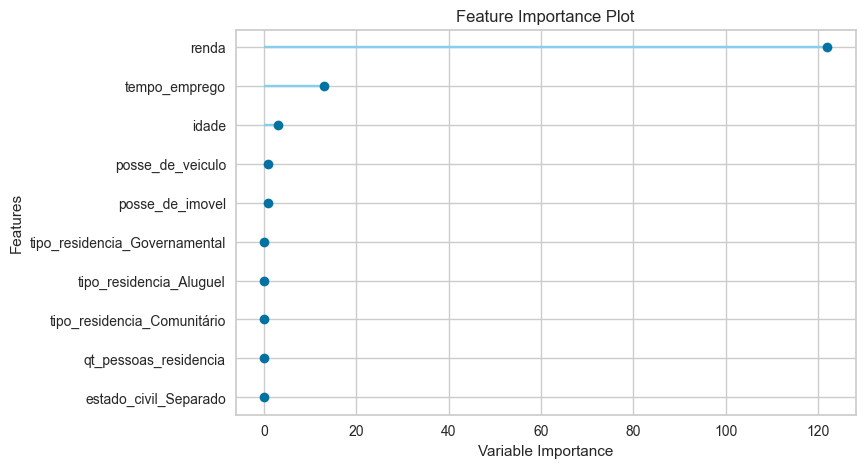

In [107]:
plot_model(gbm_tunned, plot='feature')

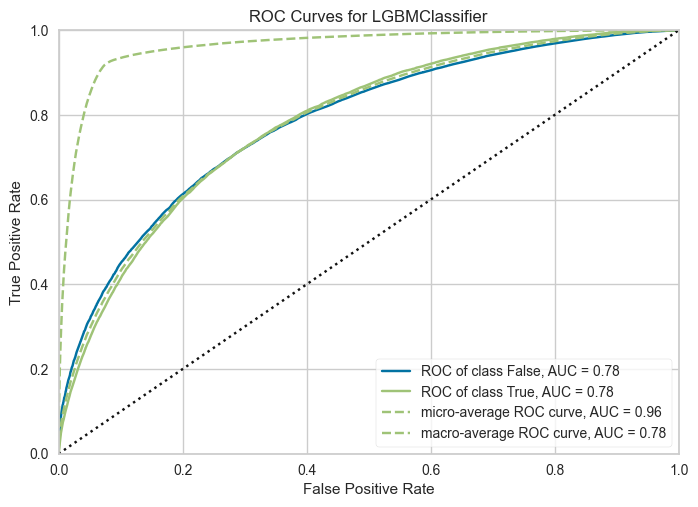

In [108]:
plot_model(gbm_tunned, plot='auc')

In [109]:
final_model = finalize_model(gbm_tunned)
print(final_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

### Salvar o arquivo do modelo treinado

In [110]:
save_model(final_model, 'model_final_pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.